![logo](./figures/LogoLine_horizon_C3S.png)

# Seasonal stripes

This Jupyter Notebook reproduces the Seasonal climate strips product from the C3S Atlas.

The seasonal stripe plot is like the [climate stripes](climate_stripes.ipynb) panel but including monthly values vertically instead of model results, displaying results for the ensemble multi-model median.

The figure below represents the seasonal climate stripe of precipitation for CMIP6 projections. It can be visualize in the C3S Atlas using the following [Permalink](https://atlas.climate.copernicus.eu/atlas/2JY592Kp)

![seasonal_stripe](./figures/pr-CMIP6_seasonal-stripes.png)

Note that climate stripes can be used for variables other than temperature to detect climate signals in the ensemble over time. In the case of the current notebook, precipitation is used

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [C3S-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](http://localhost:8889/lab/tree/book/_build/html/intro.html)

In [1]:
import os
import xarray as xr
import glob
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from c3s_atlas.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.customized_regions import (
    Mask
)
from c3s_atlas.analysis import (
    seasonal_stripes, 
)
from c3s_atlas.products import (
    seasonal_stripe_plot,
)
from c3s_atlas.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_selected_data
)

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

- Catalogue: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)
- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [2]:
project = "CMIP6"
scenario = "ssp370"
var = 'pr'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical data

In [ ]:
filename = 'pr_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'historical',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'pr_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp3_7_0',
    'domain': 'global',
    'variable': 'monthly_mean_of_daily_accumulated_precipitation',
    'area': [44.5, -9.5, 35.5, 3.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [4]:
ds_hist = xr.open_dataset(dest / "pr_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "pr_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

In [5]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

#### Select Region
The Mediterranean (MED) region is used as an example from the predefined AR6 IPCC regions ([Iturbide et al. 2020](https://doi.org/10.5194/essd-12-2959-2020)) to visualize the products. See customized_regions.ipynb for more options and information.

In [6]:
mask = Mask(ds).regions_AR6(['MED'])
filtered_ds = ds.where(mask)

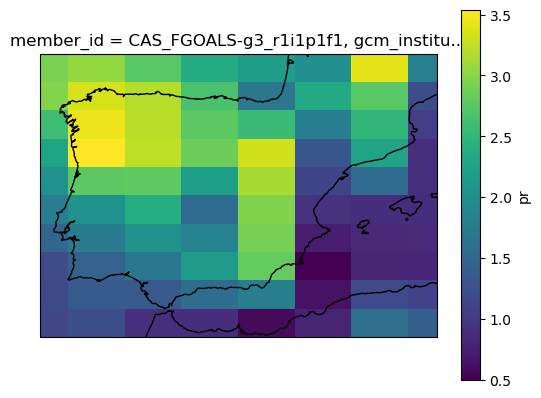

In [7]:
# mean spatial map for one member
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon projections
filtered_ds['pr'].isel(member=0).mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

### Analysis for the product
The **seasonal_stripes** funtion reshapes the dataset into a matrix with months and years as dimensions.

In [8]:
seasonal_stripes_ds = seasonal_stripes(filtered_ds, var, project)

### Plot
The **seasonal_stripe_plot** function lets you select the colorbar (cmap) used to represent the stripes. Sequential colorbars are recommended for displaying absolute values, while divergent colorbars are better suited for visualizing changes or differences, as they effectively highlight variations around a central value.

#### a) Climatology

In [9]:
mode = 'climatology'

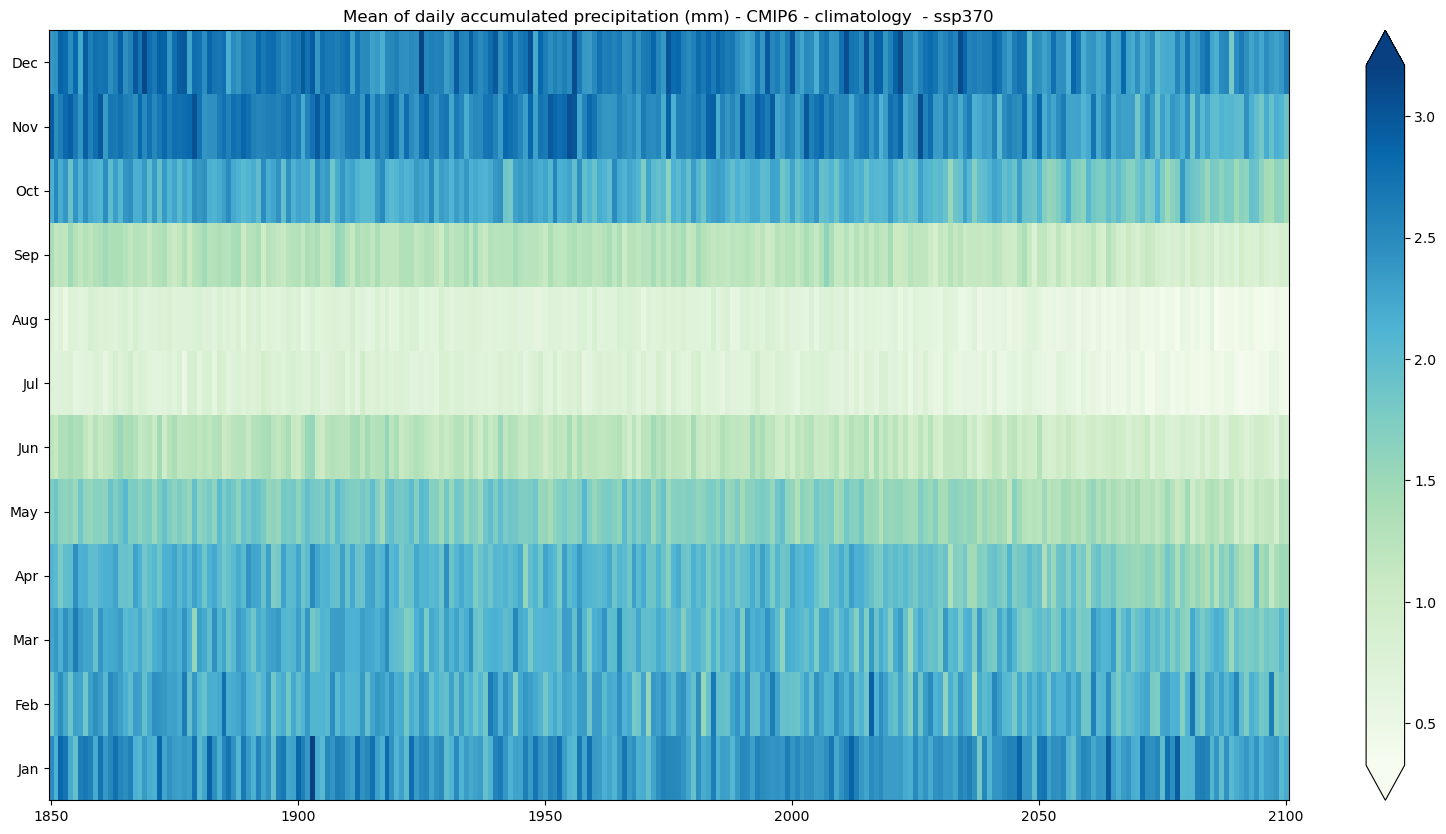

In [10]:
seasonal_stripe_fig = seasonal_stripe_plot(seasonal_stripes_ds, var, 
                                           attrs, mode = mode, cmap = 'GnBu')

#### b) Absolute change

In [11]:
mode = 'change'
diff = 'abs'
period=slice(1850, 2100)
baseline_period= slice(1981,2010)

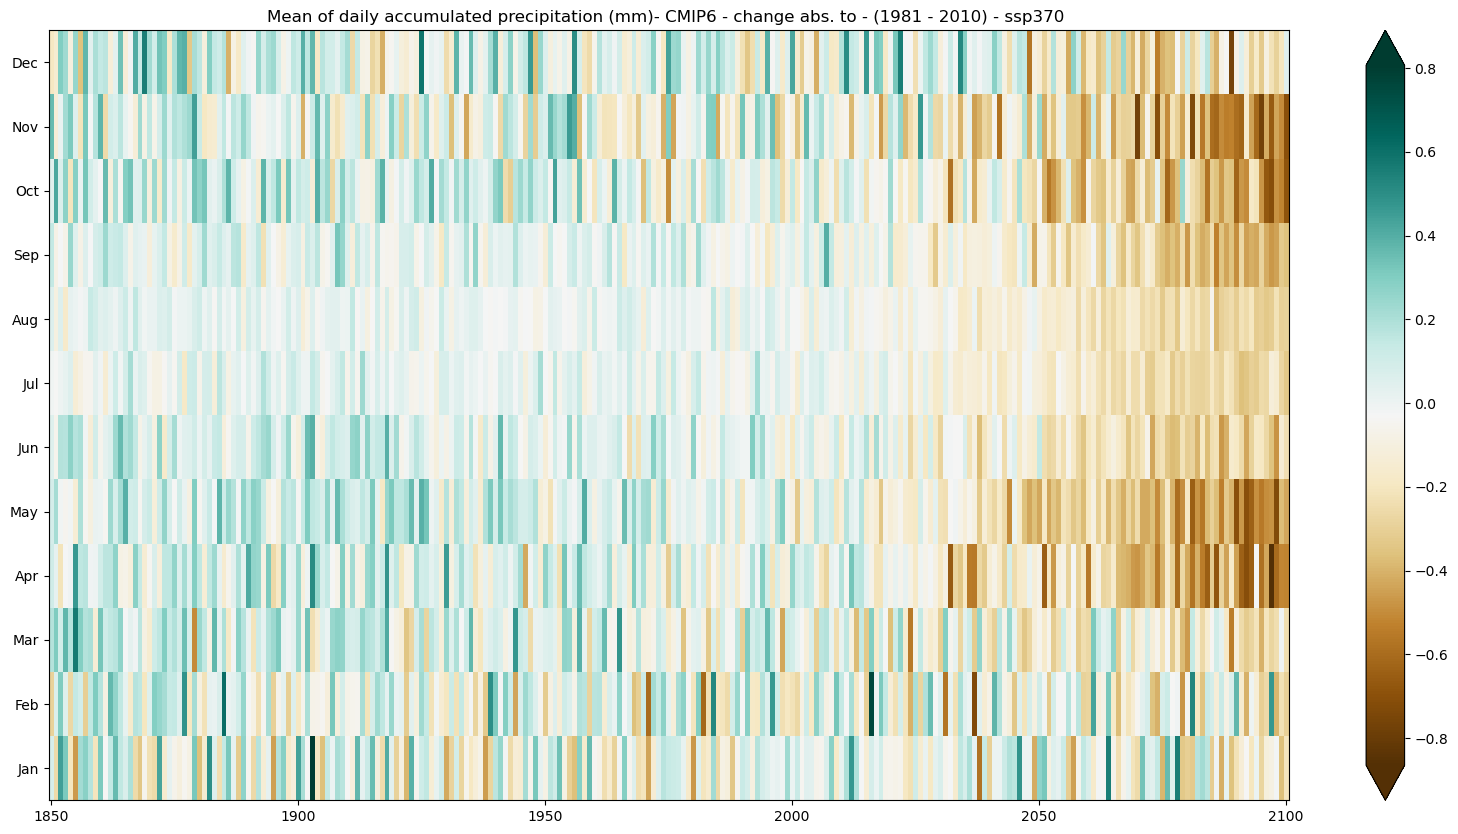

In [12]:
seasonal_stripe_fig = seasonal_stripe_plot(seasonal_stripes_ds,var, attrs, 
                                           mode = mode, diff = diff, 
                                           baseline_period = baseline_period,
                                           cmap = 'BrBG')

#### c) Relative change

In [13]:
mode = 'change'
diff = 'rel'
period=slice(1850, 2100)
baseline_period = slice(1981,2010)

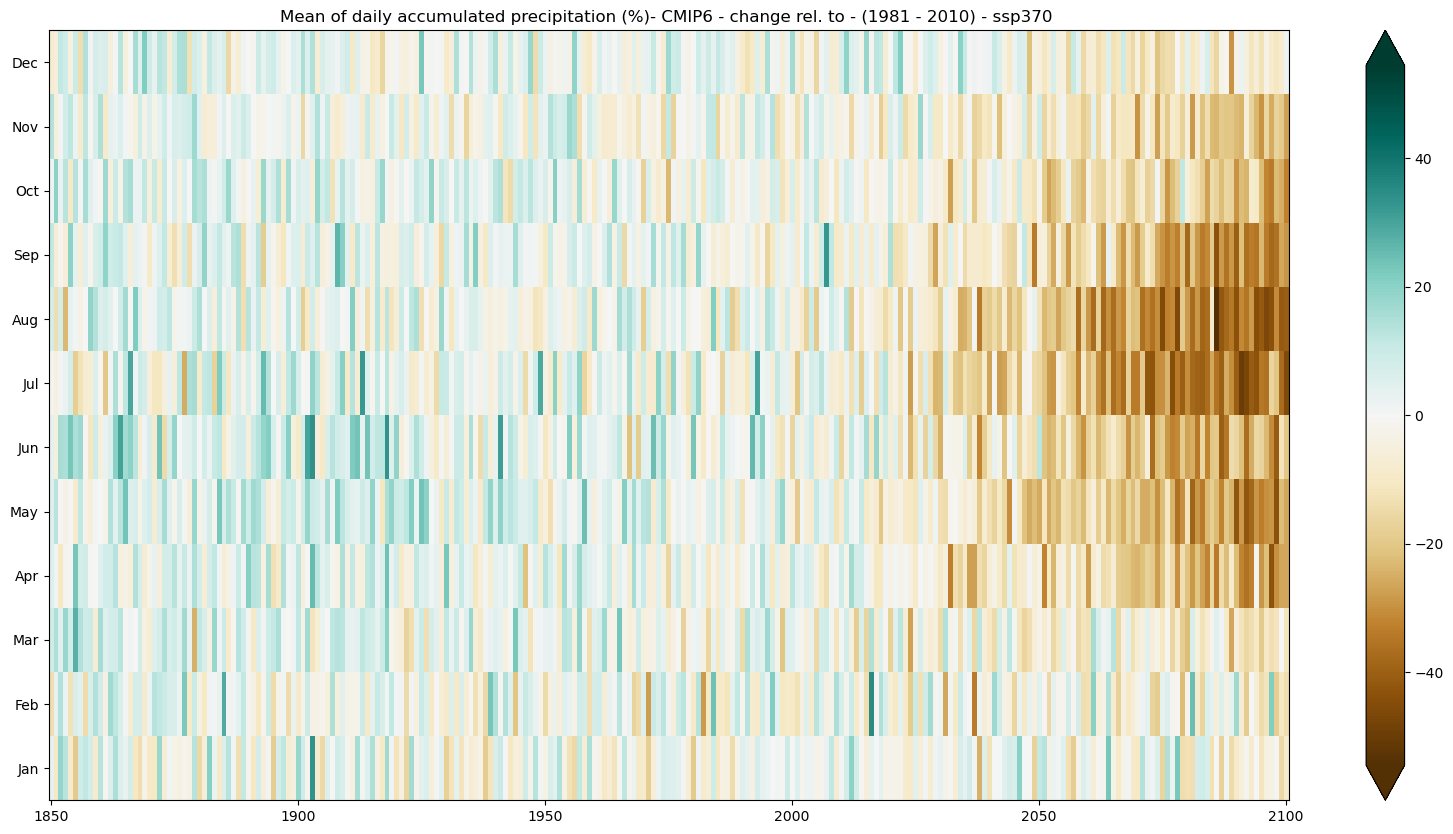

In [14]:
seasonal_stripe_fig = seasonal_stripe_plot(seasonal_stripes_ds,var, attrs, 
                                           mode = mode, diff = diff, 
                                           baseline_period = baseline_period,
                                           cmap = 'BrBG')

## Global Warning Levels
Here, the seasonal stripe is displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The seasonal stripe is then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [15]:
GWL = '4'

In [16]:
#Load the data and get the intersection of the members
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(filtered_ds, GWLs_ds, project, scenario, GWL)

In [17]:
filtered_GWLs_ds = get_selected_data(filtered_ds, GWLs_members_with_period)

In [18]:
seasonal_stripes_GWLs_ds = seasonal_stripes(filtered_GWLs_ds, var, project)

In [19]:
mode = 'change'
diff = 'rel'
baseline_period = slice(1981,2010)

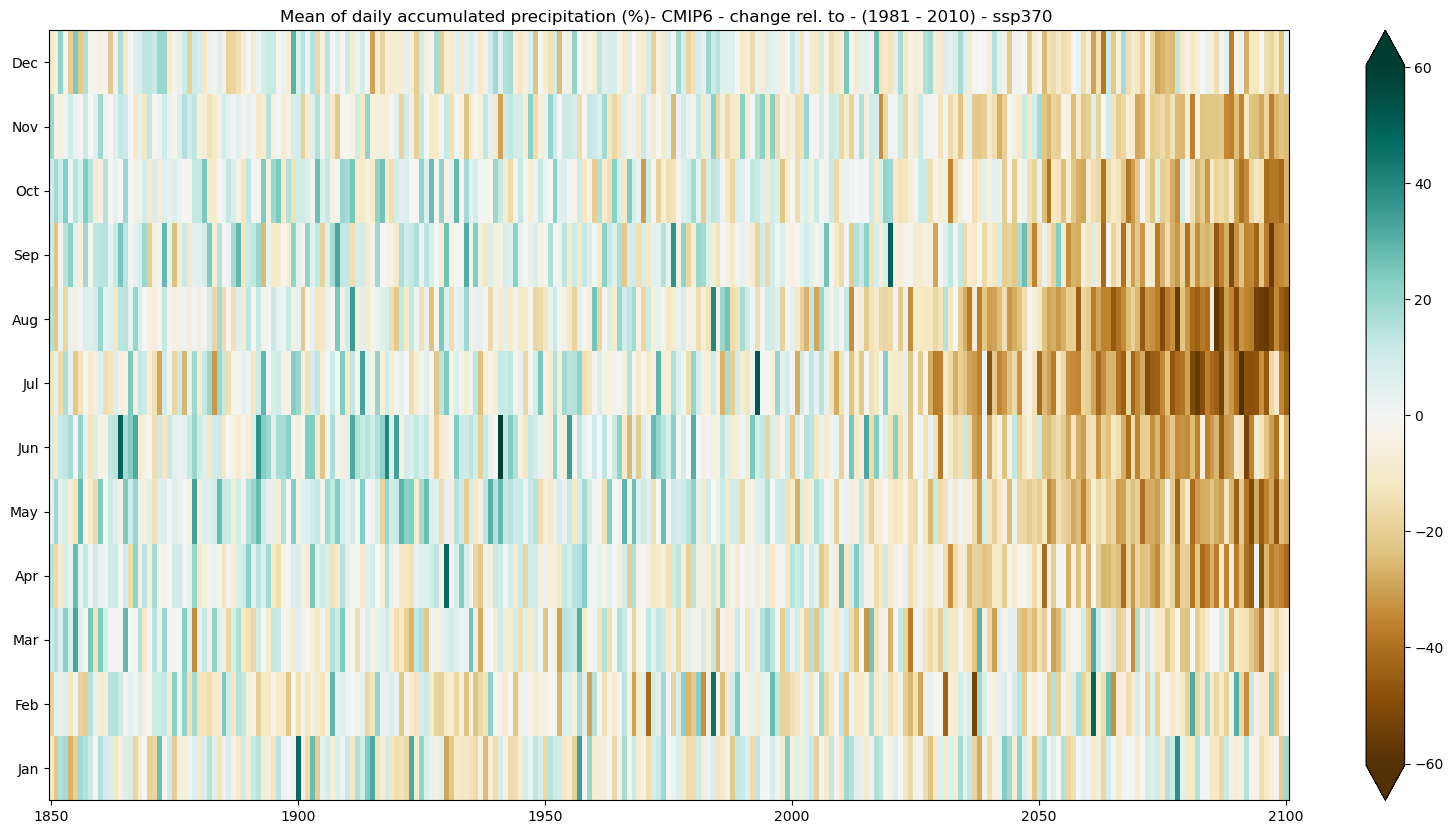

In [20]:
seasonal_stripe_fig = seasonal_stripe_plot(seasonal_stripes_GWLs_ds,var, 
                                           attrs, mode = mode, diff = diff, 
                                           baseline_period = baseline_period,
                                           cmap = 'BrBG')